# CUPED

We call 'Controlled-experiment Using Pre-Experiment Data' (CUPED) a scenario where a treatment is randomly assigned to participants, and we have pre-experiment data of participants like pre-treatment outcome.

Treatment - new product category for users.

We will test hypothesis:

$H_o$ - There is no difference in LTV between treatment and control groups.

$H_a$ - There is a difference in LTV between treatment and control groups.

## Data

We will use DGP from Causalis. Read more at https://causalis.causalcraft.com/articles/make_cuped_tweedie_26

In [1]:
from causalis.scenarios.cuped.dgp import generate_cuped_tweedie_26
from causalis.data_contracts import CausalData

data = generate_cuped_tweedie_26(return_causal_data=False, include_oracle=True)
data.head()


,y,d,tenure_months,avg_sessions_week,spend_last_month,discount_rate,platform_ios,platform_web,m,m_obs,tau_link,g0,g1,cate,y_pre,_latent_A,y_pre_2
0,3.734763,0.0,14.187461,2.0,57.355300,0.158164,1.0,0.0,0.5,0.5,0.103825,8.487966,9.416605,0.928639,17.972138,0.304717,10.783283
1,0.746406,1.0,6.352893,3.0,46.700946,0.085722,0.0,0.0,0.5,0.5,0.030781,8.487966,8.753301,0.265335,0.000000,-1.039984,0.000000
2,13.040584,1.0,18.910153,9.0,80.136187,0.175115,1.0,0.0,0.5,0.5,0.357355,8.487966,12.133915,3.645949,34.771837,0.750451,24.866330
3,34.582113,1.0,7.927627,4.0,33.718224,0.152718,1.0,0.0,0.5,0.5,0.065554,8.487966,9.063025,0.575059,349.163943,0.940565,209.498366
4,0.000000,1.0,11.106925,2.0,92.064518,0.077390,0.0,0.0,0.5,0.5,0.056036,8.487966,8.977172,0.489206,0.000000,-1.951035,0.243980


In [2]:
print(f"Ground truth ATE is {data['cate'].mean()}")
print(f"Ground truth ATTE is {data[data['d'] == 1]['cate'].mean()}")

Ground truth ATE is 1.2383515933360814
Ground truth ATTE is 1.231529853520104


In [3]:
causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['avg_sessions_week', 'spend_last_month',
       'discount_rate', 'platform_ios', 'platform_web', 'y_pre', 'y_pre_2'])
causaldata

CausalData(df=(20000, 9), treatment='d', outcome='y', confounders=['avg_sessions_week', 'spend_last_month', 'discount_rate', 'platform_ios', 'platform_web', 'y_pre', 'y_pre_2'])

# EDA

In [4]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,10049,8.867136,21.097599,0.0,0.0,0.0,0.276901,9.266134,24.454852,347.095992
1,1.0,9951,9.870188,25.879015,0.0,0.0,0.0,0.000000,10.409916,27.439125,956.413897


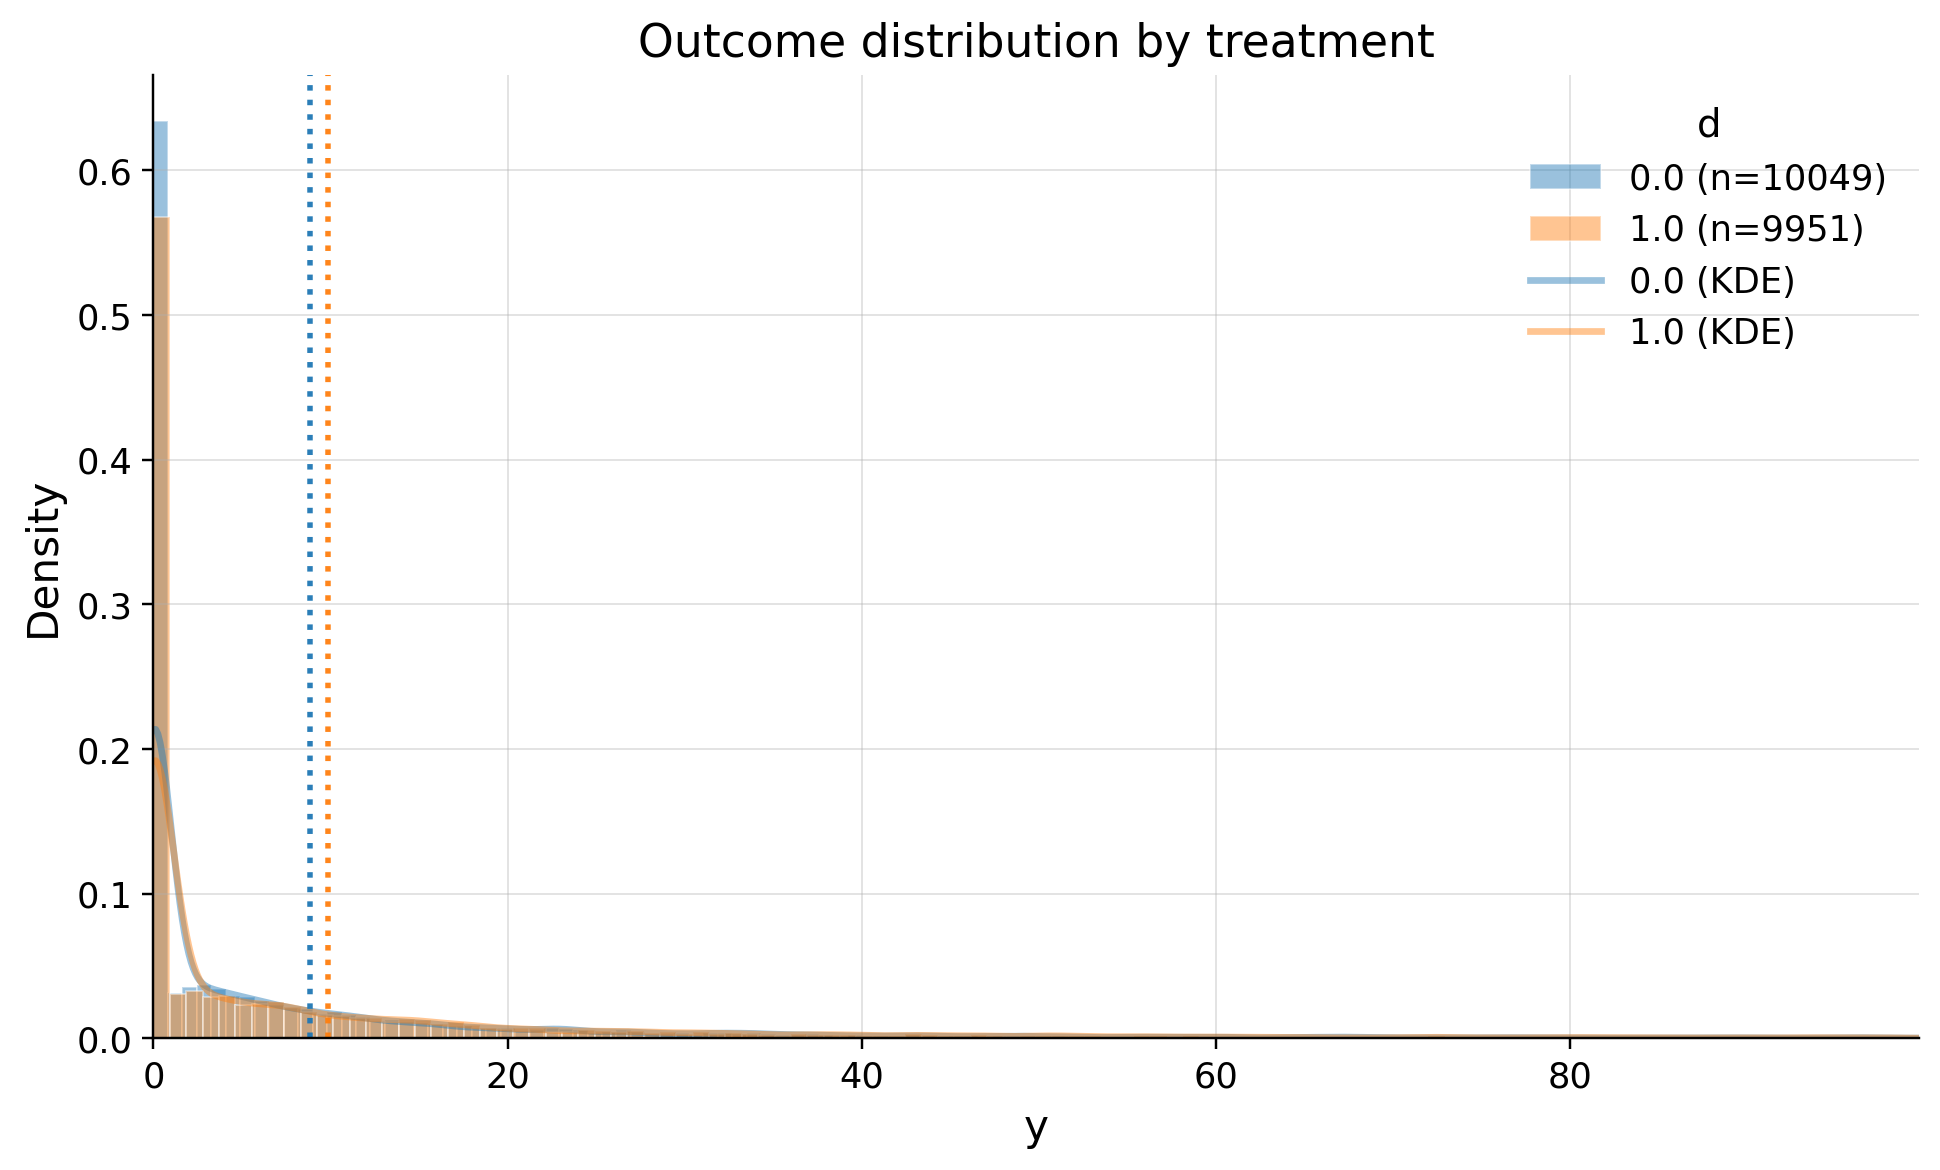

In [5]:
from causalis.shared import outcome_plot_dist, outcome_plot_boxplot
outcome_plot_dist(causaldata)

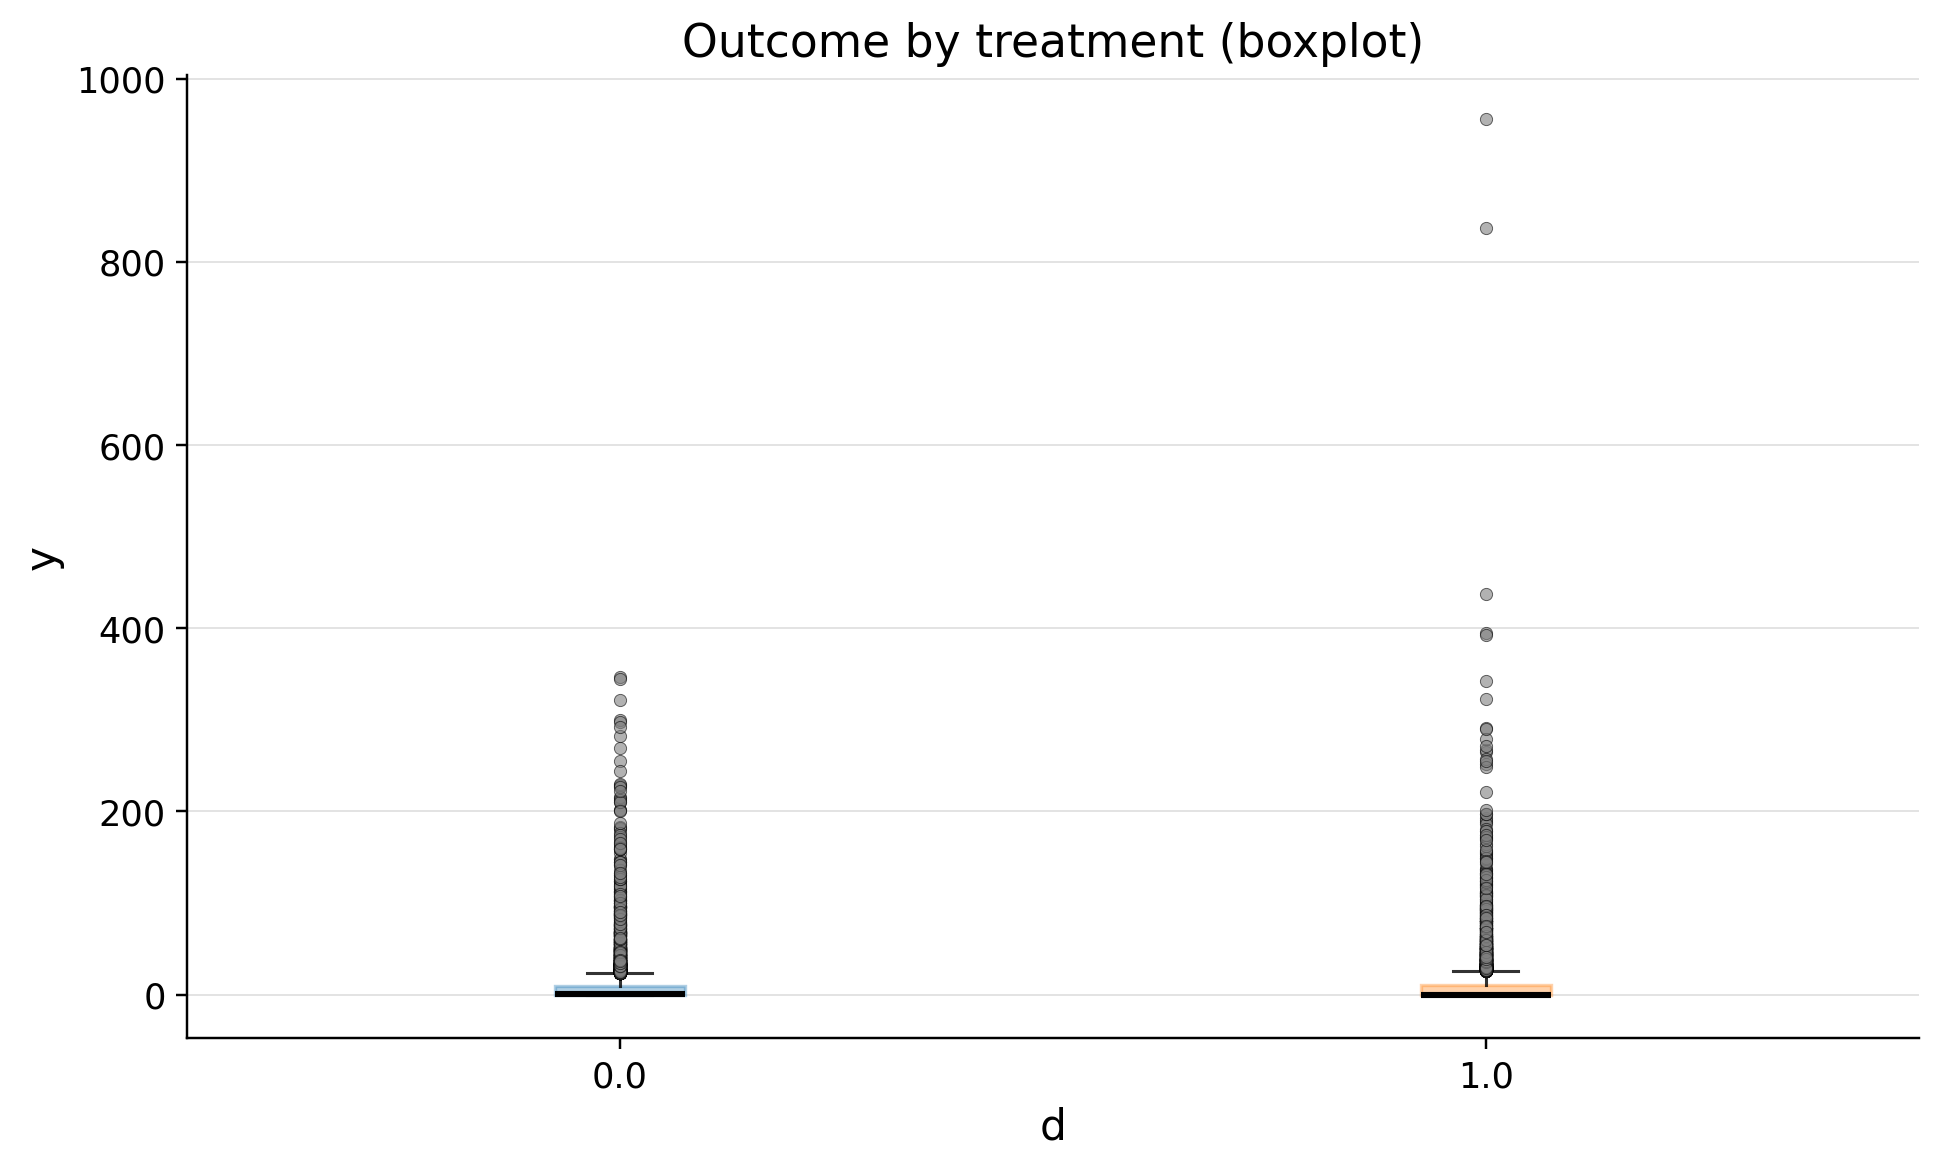

In [6]:
from causalis.shared import outcome_plot_boxplot
outcome_plot_boxplot(causaldata)

In [7]:
from causalis.shared import outcome_outliers
outcome_outliers(causaldata)

,treatment,n,outlier_count,outlier_rate,lower_bound,upper_bound,has_outliers,method,tail
0,0.0,10049,1080,0.107473,-13.899201,23.165335,True,iqr,both
1,1.0,9951,1063,0.106823,-15.614875,26.024791,True,iqr,both


We see heavy tale distribution

# Monitoring

Some system is randomly splitting users. Half must have new onboarding, other half has not. We should monitor the split with SRM test. Read more at https://causalis.causalcraft.com/articles/srm

In [8]:
from causalis.shared import check_srm

check_srm(assignments=causaldata, target_allocation={0: 0.5, 1: 0.5}, alpha=0.001)

SRMResult(status=no SRM, p_value=0.48833, chi2=0.4802)

Now let's check the balace of confounders

In [9]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,spend_last_month,73.787667,75.159017,1.371350,0.019726,0.20812
1,platform_ios,0.304309,0.297357,0.006952,-0.015158,0.96771
2,y_pre,7928.516448,20967.672427,13039.155979,0.014621,0.36084
3,y_pre_2,4760.192129,12583.709202,7823.517073,0.014621,0.38473
4,avg_sessions_week,4.963379,5.015677,0.052297,0.012405,0.49401
5,discount_rate,0.100420,0.099996,0.000424,-0.006421,0.36146
6,platform_web,0.050950,0.050749,0.000202,-0.000918,1.00000


- SRM is good
- SMD < 0.1 and ks_pvalue > 0.05

Split is random. Uncofoundedness is true

# Inference

## Math of CUPEDModel

The `CUPEDModel` implements the Lin (2013) "interacted adjustment" for ATE (Average Treatment Effect) estimation in randomized controlled trials (RCTs). This method is a robust version of ANCOVA that remains valid even when the treatment effect is heterogeneous with respect to the covariates.

### 1. Specification


The model fits an Ordinary Least Squares (OLS) regression of the outcome $Y$ on the treatment indicator $D$ and centered pre-treatment covariates $X^c$. The specification includes full interactions between the treatment and the centered covariates:

$$Y_i = \alpha + \tau D_i + \beta^T X_i^c + \gamma^T (D_i \cdot X_i^c) + \epsilon_i$$

Where:
- $Y_i$: Outcome for individual $i$.
- $D_i$: Binary treatment indicator ($D_i \in \{0, 1\}$).
- $X_i$: Vector of pre-treatment covariates.
- $X_i^c = X_i - \bar{X}$: Centered covariates (where $\bar{X}$ is the sample mean).
- $\alpha$: Intercept (represents the mean outcome of the control group when $X = \bar{X}$).
- $\tau$: **Average Treatment Effect (ATE)** or Intent-to-Treat (ITT) effect.
- $\beta$: Vector of coefficients for the main effects of the covariates.
- $\gamma$: Vector of coefficients for the interaction terms between treatment and covariates.
- $\epsilon_i$: Residual error term.

### 2. Why Centering and Interaction?

- **Centering ($X^c$):** By centering the covariates, the coefficient $\tau$ directly represents the ATE at the average value of the covariates.
- **Interactions ($D \cdot X^c$):** Including interactions (as proposed by Lin, 2013) ensures that $\tau$ is a consistent estimator of the population ATE even if the true treatment effect varies with $X$ (heterogeneity). In traditional ANCOVA without interactions, the estimator for $\tau$ can be biased or less efficient under heterogeneity.

### 3. Inference and Variance Reduction

The model uses robust covariance estimators (defaulting to `HC3`) to calculate standard errors, which accounts for potential heteroscedasticity:
- **Standard Error ($SE$):** Derived from the robust covariance matrix of the OLS fit.
- **Variance Reduction:** The main goal of CUPED is to reduce the variance of the ATE estimate by "soaking up" explainable variation in $Y$ using pre-treatment data $X$. The variance reduction percentage is calculated by comparing the variance of the adjusted model to a "naive" model ($Y \sim 1 + D$):
  $$\text{Variance Reduction \%} = 1 - \frac{Var(\hat{\tau}_{adjusted})}{Var(\hat{\tau}_{naive})}$$

### 4. Absolute and Relative Confidence Intervals


**Absolute Confidence Interval**
The $(1-\alpha)$ confidence interval for the ATE $\hat{\tau}$ is:
$$CI_{abs} = [\hat{\tau} - z_{crit} \cdot SE(\hat{\tau}), \hat{\tau} + z_{crit} \cdot SE(\hat{\tau})]$$
Where $z_{crit}$ is the critical value for the significance level $\alpha$.

**Relative Effect**
The relative effect is the ATE expressed as a percentage of the control group mean:
$$\tau_{rel} = 100\% \cdot \frac{\hat{\tau}}{\bar{Y}_C}$$
where $\bar{Y}_C$ is the sample mean of the control group.

**Relative Confidence Interval (Delta Method)**
The variance of the relative effect is estimated using the Delta Method. Assuming $\hat{\tau}$ and $\bar{Y}_C$ are approximately independent, the variance is:
$$Var(\tau_{rel}) \approx \left( \frac{100}{\bar{Y}_C} \right)^2 Var(\hat{\tau}) + \left( \frac{-100 \cdot \hat{\tau}}{\bar{Y}_C^2} \right)^2 Var(\bar{Y}_C)$$
The confidence interval for the relative effect is then:
$$CI_{rel} = [\tau_{rel} - z_{crit} \cdot \sqrt{Var(\tau_{rel})}, \tau_{rel} + z_{crit} \cdot \sqrt{Var(\tau_{rel})}]$$

In [ ]:
from causalis.scenarios.cuped.model import CUPEDModel

model = CUPEDModel().fit(causaldata, covariates=['y_pre', 'y_pre_2'])

In [11]:
result = model.estimate()
result.summary()

,value
field,
estimand,ATE
model,CUPEDModel
value,"0.8155 (ci_abs: 0.2724, 1.3587)"
value_relative,"9.1973 (ci_rel: 3.0567, 15.3378)"
alpha,0.0500
p_value,0.0033
is_significant,True
n_treated,9951
n_control,10049


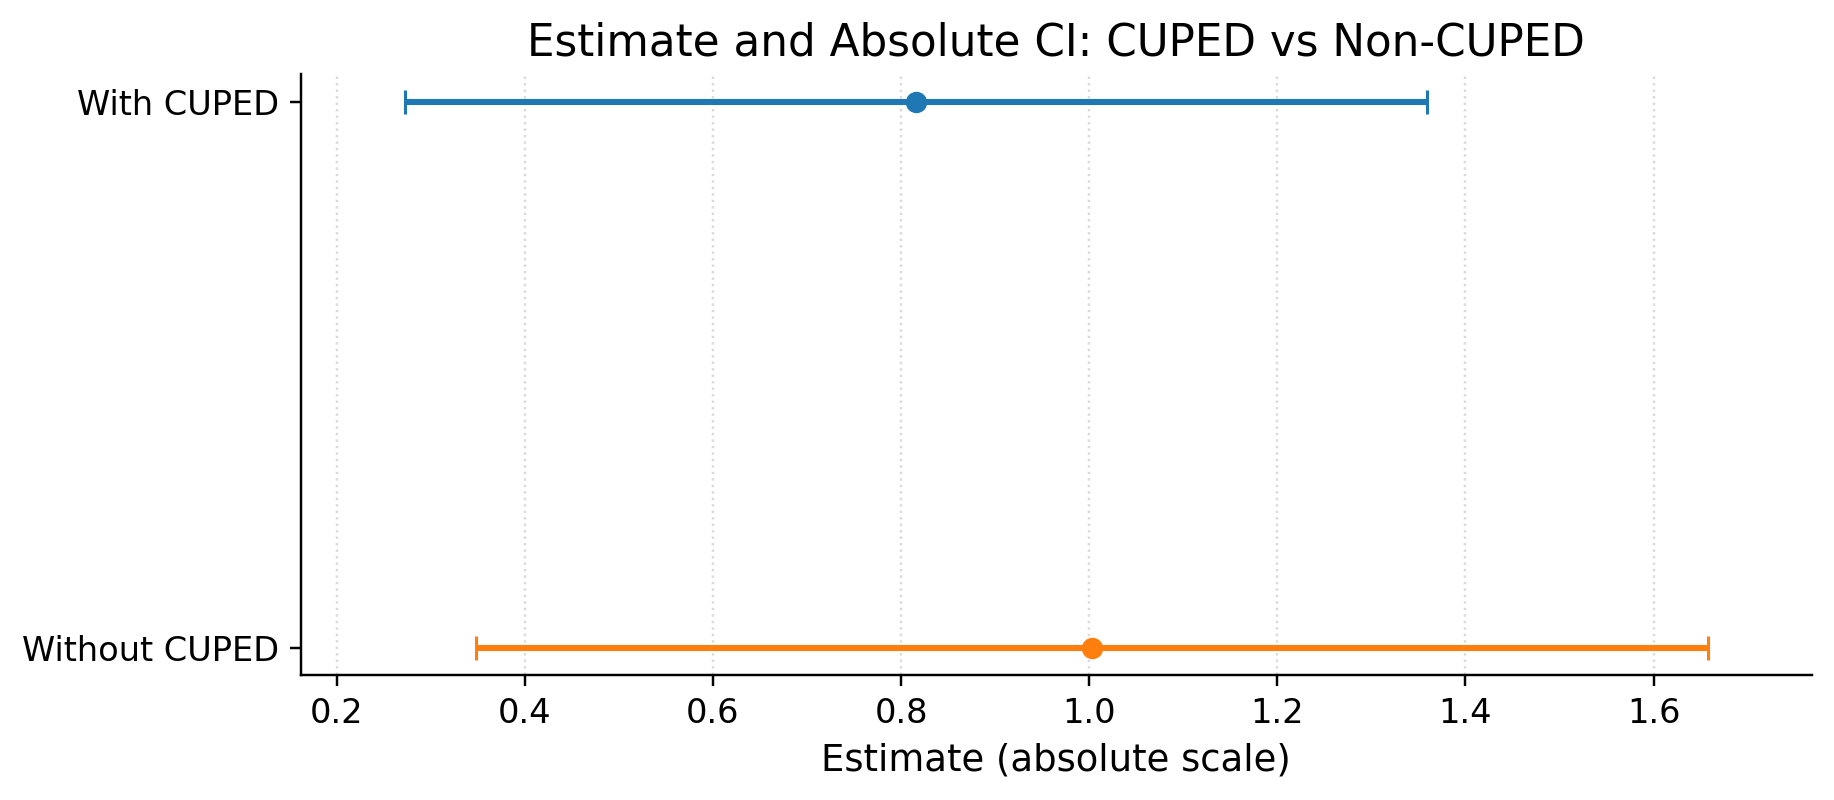

In [12]:
from causalis.scenarios.cuped import cuped_forest_plot
cuped_forest_plot(result)

In [17]:
print("var reduction with CUPED %:", result.diagnostic_data.se_reduction_pct_same_cov)

var reduction with CUPED %: 31.179433556787917


# Refutation

## Unconfoundedness

True by design. Proxy tested with SRM and balance check in Monitoring section

## SUTVA

In [14]:
from causalis.shared import print_sutva_questions
print_sutva_questions()

1.) Are your clients independent (i). Outcome of ones do not depend on others?
2.) Are all clients have full window to measure metrics?
3.) Do you measure confounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


## Overlap

Overlap is true by design

## Regression specification

In [19]:
from causalis.scenarios.cuped.diagnostics import (
    regression_assumptions_table_from_estimate,
    style_regression_assumptions_table,
)

assumptions_table = regression_assumptions_table_from_estimate(
    result,
    style_regression_assumptions_table=style_regression_assumptions_table,
)
assumptions_table

,test_id,test,flag,value,threshold,message
0,design_rank,Design rank,GREEN,"rank=6, k=6",rank == k,Design matrix is full rank.
1,condition_number,Condition number,GREEN,3335417.561616,<= 1.000e+08,Condition number is within expected range.
2,near_duplicates,Near-duplicate covariates,YELLOW,1,red if >= 3,Near-duplicate covariate pairs detected.
3,vif,Variance inflation factor,RED,6484907465.751774,"yellow: > 20, red: > 40",Very large VIF indicates severe multicollinearity.
4,ate_gap,Adjusted vs naive ATE,GREEN,0.561334,"yellow: > 2.00, red: > 2.50",Adjusted and naive ATE are reasonably aligned.
5,residual_tails,Residual extremes,RED,max|std resid|=27.8,"yellow > 7, red > 10",Extremely large standardized residuals; outliers likely dominate.
6,leverage,Leverage,RED,"max_h=0.91, n_high=653","yellow if max_h > 5*0.0006, red if max_h > max(0.5, 10*0.0006)",Extreme leverage points detected.
7,cooks,Cook's distance,RED,"max=1301, n_high=778","yellow if max Cook's > 0.1, red if > 1",Strongly influential observations detected.
8,hc23_stability,HC2/HC3 stability,GREEN,"min(1-h)=9.004e-02, n_tiny=0",min(1-h) >= 1.0e-06,HC2/HC3 stability check passed.
9,winsor_sensitivity,Winsor sensitivity,GREEN,0.304010,"yellow: > 1.00 SE, red: > 2.00 SE",Winsorized refit is close to baseline ATE.
